In [1]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

In [2]:
fileName = 'vehicles.csv'

In [3]:
car = pd.read_csv(fileName, engine='python')
car.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

Exploratory data analysis

In [33]:
# For initial modeling we are dropping data that requires significant manipulation
data = car.copy()
columns_to_drop = ['id', 'url', 'region', 'region_url', 'model','vin', 
       'image_url', 'description', 'county', 'lat', 'long']

In [34]:
data = car.drop(columns=columns_to_drop)

In [35]:
data.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')

In [36]:
# Generating a report on percentage of data unavailable 
data.isnull().sum()*100/data.count().max()

price            0.000000
year            22.440115
manufacturer    26.097245
condition       58.306929
cylinders       53.361865
fuel            22.800850
odometer        36.161252
title_status    22.672269
transmission    22.600075
drive           45.472412
size            75.787353
type            43.104160
paint_color     47.575951
state            0.000000
dtype: float64

In [37]:
# We are looking at what percentage of the data is unique 
data.nunique()*100/data.count().max()
# We see the columns - price, model and odometer have not enough unique values
# Price and odometer can be binned
# For this analysis we are dropping the 'model' column - check earlier analysis 

price            3.846816
year             0.026188
manufacturer     0.010145
condition        0.001416
cylinders        0.001887
fuel             0.001180
odometer        21.128352
title_status     0.001416
transmission     0.000708
drive            0.000708
size             0.000944
type             0.003067
paint_color      0.002831
state            0.012032
dtype: float64

In [38]:
# Removing data corresponding to very high prices for even regular cars. 
# Some prices are like 123456789 etc, so we remove around 750 data entries for cars with prices greater than
# 100000 cars
data = data[data.price < 1e6]
# Convert year to age and removing 'year' columns
data["age"] = pd.datetime.now().year - data["year"]
data = data.drop(columns="year")

C:\Users\subint\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [39]:
data = data[data['price'] >= 100]

In [40]:
data = data[data.age < 40]
data.corr()
# This correlation makes sense, the price decreases with increased age and odometer reading - therefore the correlation coefficients are -ve
# Similarly a older vehicle has a higher odometer reading - hence the correlation coefficients are +ve

,price,odometer,age
price,1.000000,-0.255527,-0.446289
odometer,-0.255527,1.000000,0.322902
age,-0.446289,0.322902,1.000000


In [41]:
# car['price'].isna()
car['year'].isna().count()
car['odometer'].isna().count()

423857

In [42]:
data['odometer'] = data['odometer'].fillna(data['odometer'].median())
data['age'] = data['age'].fillna(data['age'].median())

Text(0, 0.5, 'PDF')

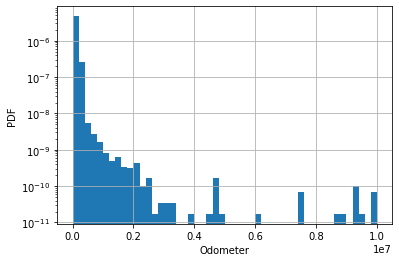

In [43]:
ax1 = data['odometer'].hist(bins=50, density=True)
ax1.set_yscale('log')
ax1.set_xlabel('Odometer')
ax1.set_ylabel('PDF')

Text(0, 0.5, 'PDF')

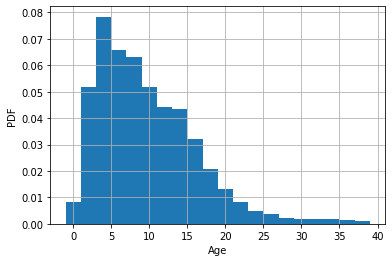

In [44]:
ax1 = data['age'].hist(bins=20, density=True)
ax1.set_xlabel('Age')
ax1.set_ylabel('PDF')

Text(0, 0.5, 'PDF')

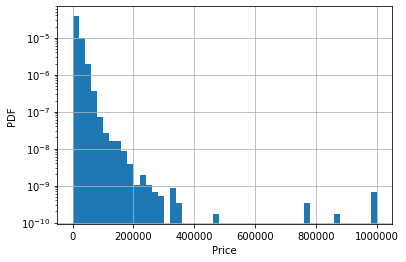

In [45]:
ax1 = data['price'].hist(bins=50, density=True)
ax1.set_yscale('log')
ax1.set_xlabel('Price')
ax1.set_ylabel('PDF')

In [46]:
data["odometer"] = data["odometer"]/(data["odometer"].max() - data["odometer"].min())
data["age"] = data["age"]/(data["age"].max() - data["age"].min())
data["price"] = data["price"]/(data["price"].max() - data["price"].min())

In [47]:
le = preprocessing.LabelEncoder()

In [48]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
objList = data.select_dtypes(include = "object").columns
numList = data.select_dtypes(include = numerics).columns
# print (objList)
# print (numList)

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = pd.DataFrame()

for x in numList:
    df[x] = data[x].copy()

for x in objList:
    df[x] = data[x].copy()
    df[pd.isnull(data[x])].loc[x] = data[x].value_counts().idxmax()
    df[x] = le.fit_transform(df[x].astype(str))

C:\Users\subint\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [50]:
price = df["price"].copy()
df = df.drop(columns=["price"])

In [51]:
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(df, price, train_size=0.6, test_size=0.4,
                                                      random_state=0)
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    y_pred = model.predict(X_v)
    return r2_score(y_v,y_pred)


In [52]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

score_model(reg, X_train, X_valid, y_train, y_valid)

0.28250339721711104

In [53]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [58]:
data.isna().sum()

price                0
manufacturer     12160
condition       130155
cylinders       113478
fuel              1943
odometer             0
title_status      1405
transmission      1261
drive            85071
size            200535
type             77633
paint_color      92061
state                0
age                  0
dtype: int64